<a href="https://colab.research.google.com/github/neo09sumedh/BERT-LLM/blob/main/Copy_of_Project_Phase_2_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade transformers datasets torch

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas as pd

# Ensure you have a GPU available for faster training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Step 1: Load and preprocess the dataset
# Example: Load a CSV dataset with 'text' and 'label' columns
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)  # Replace with your dataset
texts = df[0].tolist()
labels = df[1].tolist()

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset Preparation
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)


train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Step 2: Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # Adjust num_labels based on classes
model.to(device)

# Step 3: Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 4  # Assume 4 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()
train_losses = []
train_acc = 0.0
# Step 4: Training Loop
epochs = 4
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")
test_losses = []
test_acc = 0.0
total_test_loss = 0
for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_test_loss += loss.item()
        test_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

# Step 5: Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
       # accuracy = accuracy_score(predictions, true_labels)
        #print(f"Accuracy: {accuracy}")

print(classification_report(true_labels, predictions, target_names=["Negative", "Positive"]))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Loss: 0.3615070280613582
Epoch 2/4, Loss: 0.12276784433025027
Epoch 3/4, Loss: 0.03484091185493599
Epoch 4/4, Loss: 0.008325176859258357
              precision    recall  f1-score   support

    Negative       0.93      0.90      0.91       671
    Positive       0.91      0.94      0.92       713

    accuracy                           0.92      1384
   macro avg       0.92      0.92      0.92      1384
weighted avg       0.92      0.92      0.92      1384



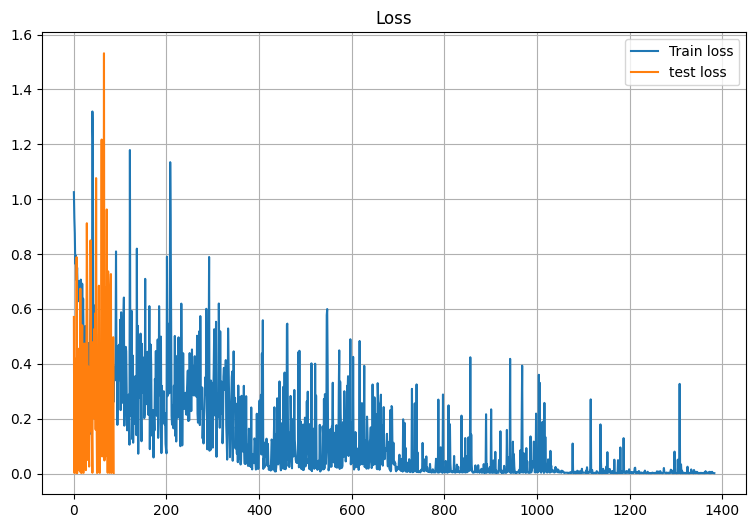

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='test loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


In [ ]:
model.save_pretrained("bert-sentiment")
tokenizer.save_pretrained("bert-sentiment")


('bert-sentiment/tokenizer_config.json',
 'bert-sentiment/special_tokens_map.json',
 'bert-sentiment/vocab.txt',
 'bert-sentiment/added_tokens.json')

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

model = BertForSequenceClassification.from_pretrained("bert-sentiment")
tokenizer = BertTokenizer.from_pretrained("bert-sentiment")
model.to(device)

# Inference Function
def predict_sentiment(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_label = torch.argmax(probabilities, dim=-1).item()

    # Label mapping
    label_map = {0: "Negative", 1: "Positive"}
    sentiment = label_map[predicted_label]
    return sentiment, probabilities.cpu().numpy()

# Example usage
texts = [
    "I love this product, it's amazing!",
    "This is the worst experience I've ever had.",
    "Movie is great"
]

for text in texts:
    sentiment, probabilities = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text}\nSentiment: {sentiment}\nProbabilities: {probabilities}\n")


Text: I love this product, it's amazing!
Sentiment: Positive
Probabilities: [[2.5405036e-04 9.9889708e-01 8.4886572e-04]]

Text: This is the worst experience I've ever had.
Sentiment: Negative
Probabilities: [[9.9914432e-01 5.6705764e-04 2.8863206e-04]]

Text: Movie is great
Sentiment: Positive
Probabilities: [[3.0152517e-04 9.9907339e-01 6.2504469e-04]]

